# Random parameter sweeps for Thesis - Fisher Info and characterisation plots


Vary most parameters randomly, checking usual metrics when no data is available.

Will need to filter and plot parameter effects afterwards.


In [198]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [200]:
with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fisher2016_random_large_300816.py

In [201]:
def avg_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(array, axis=-1))]
def avg_twice_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(utils.nanmean(array, axis=-1), axis=-1))]
def process_marginal_fi(array_name, array):
    # Marginal FI/Inv FI have (mean, std), just keep mean
    return [(array_name, utils.nanmean(array, axis=-1)[:, 0])]
def process_em_fits(array_name, array):
    emfits_all = utils.nanmean(array, axis=-1)
    outputs = [(array_name + "_" + colname, emfits_all[:, col_i])
            for col_i, colname in enumerate(['kappa',
                                             'target',
                                             'nontargets',
                                             'random',
                                             'LL',
                                             'bic'])
              ]
    outputs.append((array_name + '_fidelity', 1./utils.kappa_to_stddev(emfits_all[:, 0])**2.))
    
    return outputs
    
def construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions):
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    filter_data = None
    result_parameters_flat = None

    pandas_column_data = []

    for result_array_name, result_processing in pandas_columns_with_processing:
        # Extract data
        res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'])

        # Filter completed only
        if filter_data is None:
            repeats_completed = data_pbs.dict_arrays[result_array_name]['repeats_completed']
            filter_data = repeats_completed == (num_repetitions - 1)
        res_array = res_array[filter_data]

        # Keep parameters
        if result_parameters_flat is None:
            result_parameters_flat = np.array(data_pbs.dict_arrays[result_array_name]['parameters_flat'])
            result_parameters_flat = result_parameters_flat[filter_data]

        # Transform into list of columns for Pandas
        pandas_column_data.extend(result_processing['process'](result_processing['name'], res_array))

    # Add all parameters to Pandas columns
    for param_i, param_name in enumerate(parameter_names_sorted):
        pandas_column_data.append((param_name, result_parameters_flat[:, param_i]))
    
    df_all_results = pd.DataFrame.from_items(pandas_column_data)    
    return df_all_results

In [202]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

T_space = data_pbs.loaded_data['parameters_uniques']['T']
M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']
sigmabase_space = data_pbs.loaded_data['parameters_uniques']['sigma_baseline']

pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=avg_lastaxis)),
    ('result_FI_rc_curv', dict(name='fi_curv', process=avg_twice_lastaxis)),
    ('result_FI_rc_theo', dict(name='fi_theo', process=avg_twice_lastaxis)),
    ('result_FI_rc_theocov', dict(name='fi_theo_cov', process=avg_twice_lastaxis)),
    ('result_marginal_FI', dict(name='fi_marginal', process=process_marginal_fi)),
    ('result_marginal_inv_FI', dict(name='inv_fi_marginal', process=process_marginal_fi)),
    ('result_em_fits', dict(name='emfit', process=process_em_fits)),
]

df_all_fits = construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)

In [203]:
df_all_fits.describe()

,precision,fi_curv,fi_theo,fi_theo_cov,fi_marginal,inv_fi_marginal,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,T,M,ratio_conj,sigmax,sigma_baseline
count,2875.000000,2875.000000,2875.000000,2875.000000,2875.000000,2.875000e+03,2875.000000,2875.000000,2875.000000,2.875000e+03,2875.000000,2875.000000,2875.000000,2875.000000,2875.000000,2875.000000,2875.000000,2875.000000
mean,37.457083,1095.546930,795.076143,793.310889,820.460141,1.196029e+16,786.418243,0.398918,0.189279,4.118030e-01,-211.261122,449.002774,785.901233,2.997913,304.674087,0.478599,0.402347,0.394299
std,516.950713,2844.185018,2760.440861,2820.277574,2856.017454,4.382981e+17,6067.437357,0.282335,0.182447,2.866426e-01,189.793338,381.645467,6067.439525,1.412242,172.982549,0.286112,0.230721,0.226607
min,0.134057,0.020398,0.000249,0.000250,0.000379,-6.036147e+16,0.419667,0.000394,0.000000,7.295952e-12,-367.441831,-1321.840943,0.315844,1.000000,4.000000,0.000000,0.010303,0.010190
25%,0.276047,33.533484,17.246902,17.045068,17.516511,1.777688e-03,11.386615,0.156295,0.049263,1.548881e-01,-340.673065,343.722336,10.865520,2.000000,153.500000,0.224296,0.201098,0.196824
50%,0.466646,198.475170,91.812811,90.151222,93.590475,1.075346e-02,52.169612,0.343284,0.140473,4.036220e-01,-288.897629,603.096161,51.665507,3.000000,299.000000,0.471698,0.401757,0.386733
75%,1.012566,1062.171303,544.630331,535.531444,561.835996,5.844798e-02,413.934345,0.605826,0.284297,6.482485e-01,-158.252646,710.336056,413.433840,4.000000,453.500000,0.726192,0.603195,0.585690
max,18377.196966,50491.656623,52112.359585,57171.158084,55344.101404,1.912526e+19,220866.027240,1.000000,0.820493,9.890832e-01,668.867947,771.971883,220865.527244,5.000000,623.000000,1.000000,0.799937,0.798888


In [213]:
# Remove outliers
df_fits_filtered = df_all_fits[np.all(np.abs(spst.zscore(df_all_fits)) < 3, axis=1)]

In [214]:
df_fits_filtered.describe()

,precision,fi_curv,fi_theo,fi_theo_cov,fi_marginal,inv_fi_marginal,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,T,M,ratio_conj,sigmax,sigma_baseline
count,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2.750000e+03,2750.000000,2750.000000,2750.000000,2.750000e+03,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000,2750.000000
mean,3.231126,745.318834,446.520271,441.020966,460.467191,1.149344e+13,378.116238,0.389525,0.184084,4.263909e-01,-232.874758,492.287343,377.598545,3.008727,301.057818,0.486539,0.413335,0.404143
std,23.162523,1274.999685,912.011098,903.745996,943.105122,2.572330e+15,940.751003,0.274803,0.171947,2.799399e-01,151.026270,304.123207,940.757874,1.405672,171.614481,0.285686,0.226795,0.224060
min,0.134057,0.022291,0.000333,0.000331,0.000503,-6.036147e+16,0.419667,0.000394,0.000000,1.708916e-10,-367.425751,-691.548740,0.315844,1.000000,4.000000,0.000000,0.010303,0.010430
25%,0.275246,31.874742,16.677546,16.487037,16.913428,2.176596e-03,11.064724,0.151249,0.052917,1.819539e-01,-341.408289,390.807349,10.542908,2.000000,152.000000,0.233937,0.218195,0.216725
50%,0.460602,178.753773,83.981517,82.579496,85.472236,1.183249e-02,43.560352,0.335880,0.140523,4.237860e-01,-292.658731,612.963461,43.055408,3.000000,294.500000,0.477696,0.414750,0.398561
75%,0.953026,913.896325,443.138047,436.676025,455.736908,6.139370e-02,333.766923,0.587686,0.278386,6.561470e-01,-181.623606,711.434745,333.266296,4.000000,448.000000,0.739577,0.611942,0.590855
max,521.414691,9478.146841,7675.775874,7675.775874,7906.009221,1.147503e+17,17176.304317,1.000000,0.736514,9.879932e-01,356.371005,771.238743,17175.804305,5.000000,623.000000,1.000000,0.799937,0.798888


In [215]:
def str_best_params(best_i, result_dist_to_use):
    return '[{:3d}] '.format(best_ind) + ' '.join(["%s %.4f" % (parameter_names_sorted[param_i], result_parameters_flat[best_i, param_i]) 
                     for param_i in xrange(len(parameter_names_sorted))]) + ' >> %f' % result_dist_to_use[best_i]


In [216]:
def sort_df_best_params(df_to_use, metric, nb_params):
    return df_to_use.sort(metric)[:nb_params]

def print_str_best_params_df(df_to_use, metric, nb_params):
    df_sorted = sort_df_best_params(df_to_use, metric, nb_params)
    
    metric_space = ['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_bic']
    
    print 'Best for %s' % metric
    print '[  i ] ' + ' '.join(["%s" % param for param in parameter_names_sorted]) + \
    ' >> ' + ' '.join(["%s" % metric for metric in metric_space])
    
    for row_i, row in df_sorted.iterrows():
        print "[{:4d}] ".format(row_i) + \
        ' '.join(["%.4f" % (row[param]) for param in parameter_names_sorted]) + \
        ' >> ' + ' '.join(["%.4f" % row[curr_metric] for curr_metric in metric_space])


## -> Pandas now

In [217]:
## Correlations
df_fits_filtered.corr()

,precision,fi_curv,fi_theo,fi_theo_cov,fi_marginal,inv_fi_marginal,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,T,M,ratio_conj,sigmax,sigma_baseline
precision,1.000000,-0.000554,0.033745,0.034934,0.032609,-0.000569,-0.010973,0.257628,-0.120844,-0.178675,0.353320,-0.354092,-0.010971,-0.129748,0.037907,0.086343,-0.141706,-0.115870
fi_curv,-0.000554,1.000000,0.964177,0.961852,0.964231,-0.002610,0.654244,-0.227185,0.076209,0.176206,0.289968,-0.289376,0.654249,-0.056464,0.489103,-0.492504,-0.173245,-0.111550
fi_theo,0.033745,0.964177,1.000000,0.999729,0.999963,-0.002187,0.590137,-0.085630,0.107057,0.018302,0.421392,-0.420958,0.590141,-0.099445,0.405227,-0.398576,-0.246406,-0.142014
fi_theo_cov,0.034934,0.961852,0.999729,1.000000,0.999674,-0.002180,0.589312,-0.082162,0.104860,0.016246,0.424134,-0.423768,0.589316,-0.102951,0.402594,-0.397062,-0.248044,-0.138677
fi_marginal,0.032609,0.964231,0.999963,0.999674,1.000000,-0.002182,0.590604,-0.086515,0.107483,0.018909,0.419967,-0.419531,0.590609,-0.098943,0.404690,-0.398628,-0.245593,-0.141557
inv_fi_marginal,-0.000569,-0.002610,-0.002187,-0.002180,-0.002182,1.000000,0.015316,-0.006225,0.020237,-0.006319,-0.003622,0.004020,0.015315,0.017243,-0.007438,0.041286,-0.006997,0.043969
emfit_kappa,-0.010973,0.654244,0.590137,0.589312,0.590604,0.015316,1.000000,-0.245195,-0.011443,0.247725,0.094919,-0.094045,1.000000,0.009275,0.316683,-0.394631,-0.008492,-0.046307
emfit_target,0.257628,-0.227185,-0.085630,-0.082162,-0.086515,-0.006225,-0.245195,1.000000,-0.282700,-0.808008,0.693164,-0.698176,-0.245197,-0.397385,-0.031337,0.616648,-0.468490,-0.211332
emfit_nontargets,-0.120844,0.076209,0.107057,0.104860,0.107483,0.020237,-0.011443,-0.282700,1.000000,-0.336714,-0.020896,0.034678,-0.011449,0.568600,-0.380033,-0.197055,-0.297285,-0.080820
emfit_random,-0.178675,0.176206,0.018302,0.016246,0.018909,-0.006319,0.247725,-0.808008,-0.336714,1.000000,-0.667609,0.664064,0.247730,0.040844,0.264188,-0.484296,0.642494,0.257096


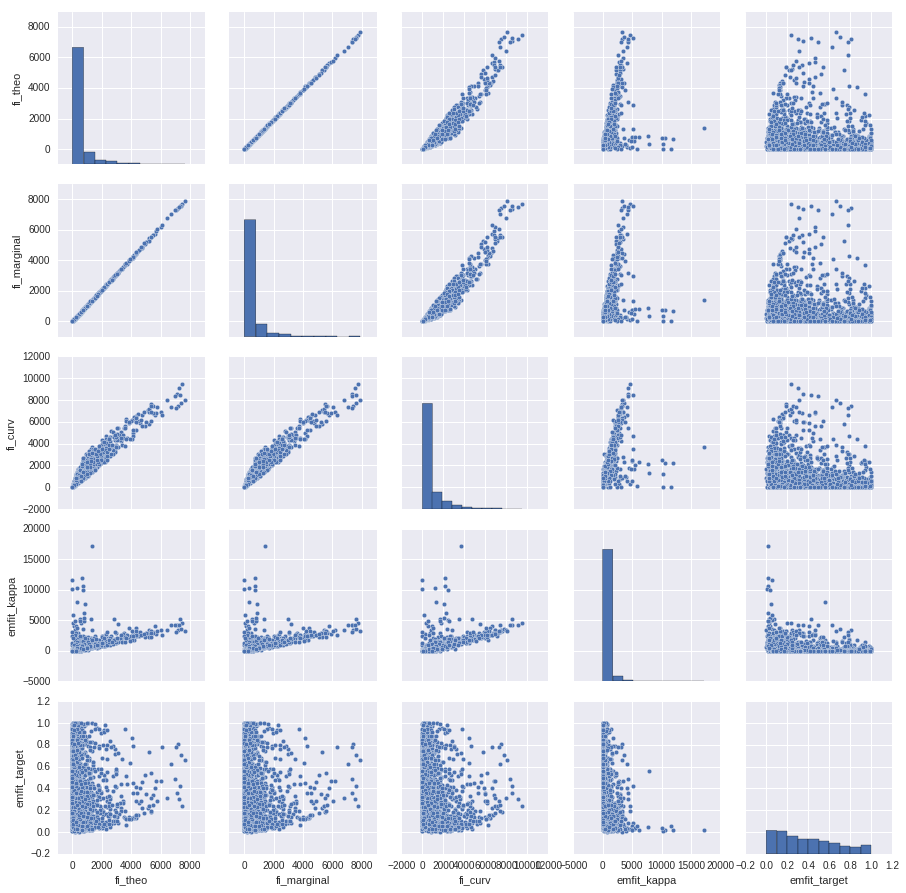

In [221]:
# Cross-correlation plots
sns.pairplot(df_fits_filtered,
             x_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa', 'emfit_target'],
             y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa', 'emfit_target'],
            )

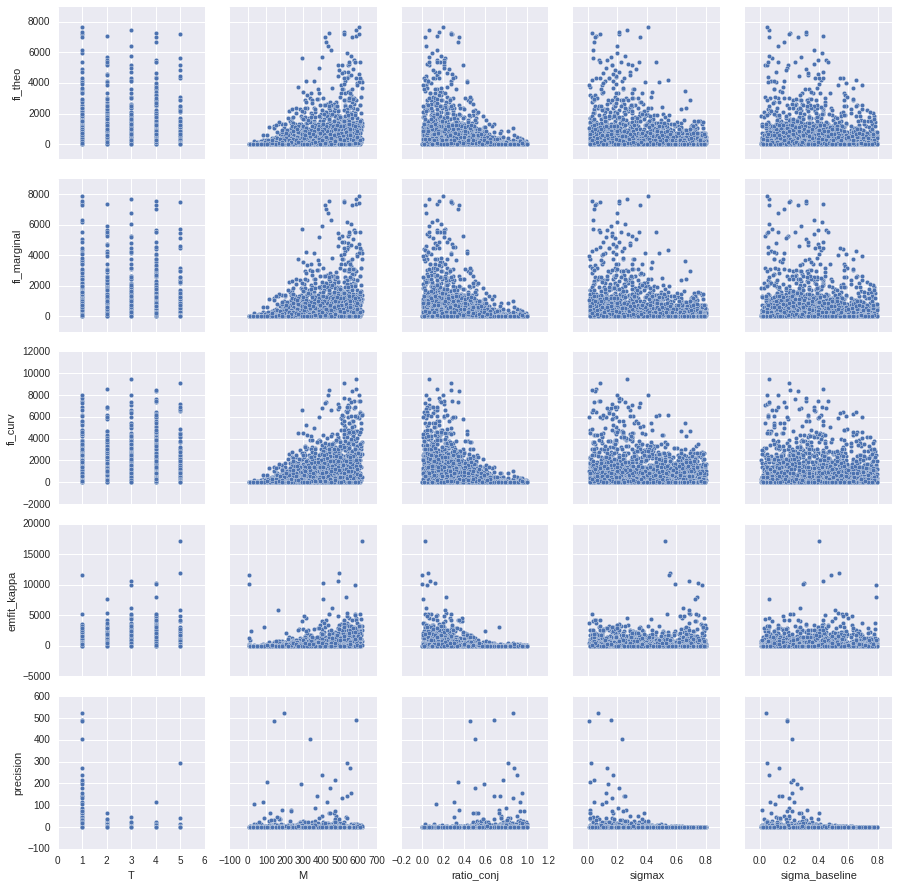

In [219]:
# Check parameters effects
sns.pairplot(df_fits_filtered,
             x_vars=parameter_names_sorted,
             y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa', 'precision']
            )

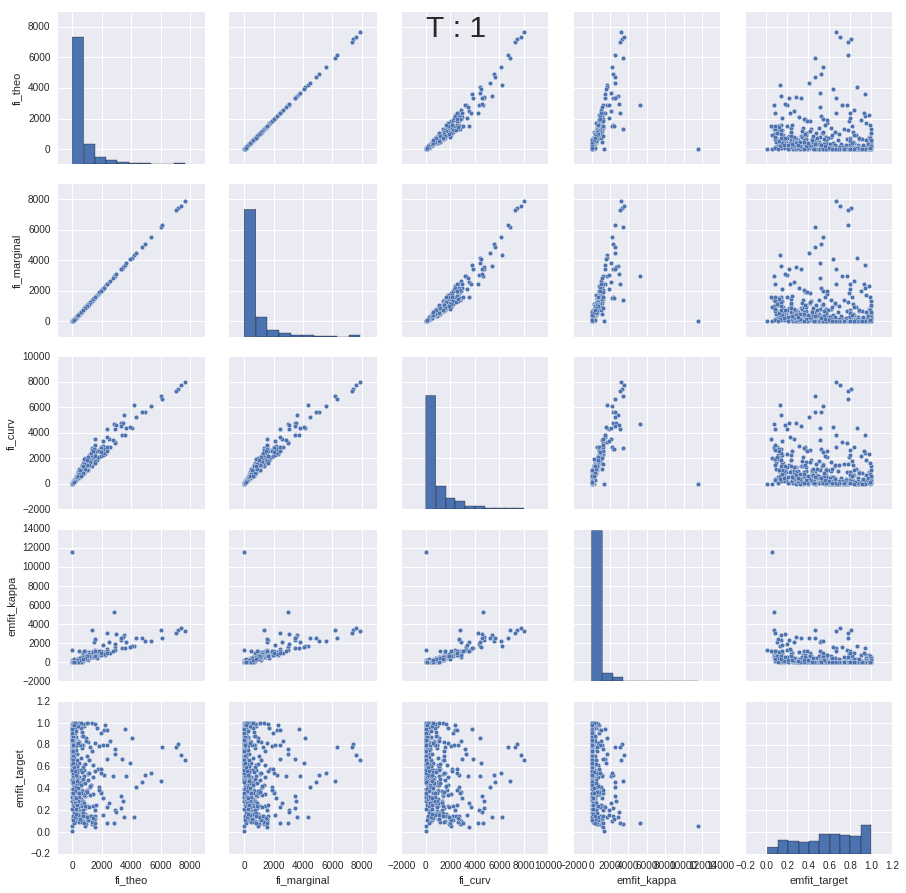

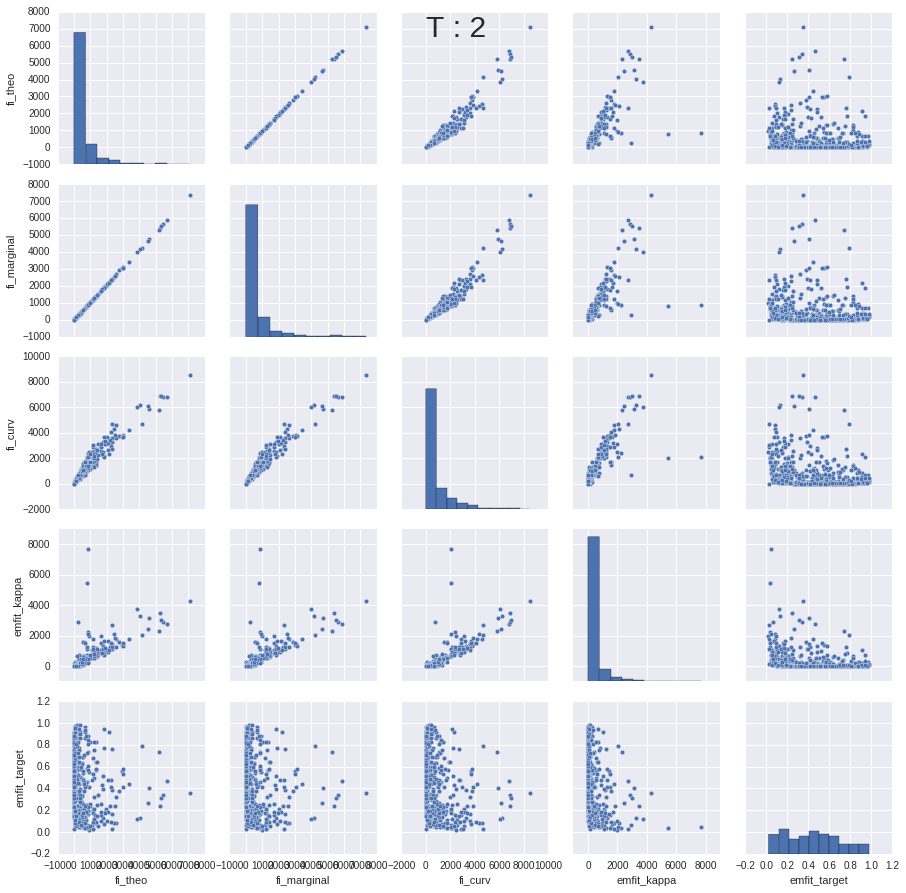

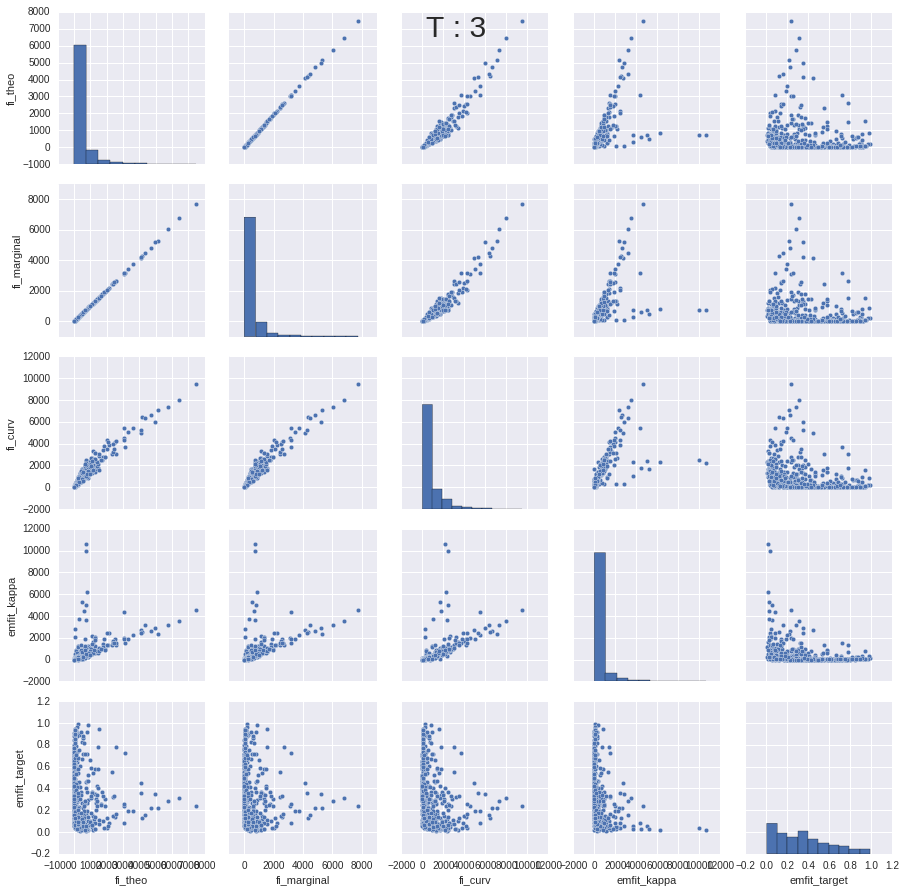

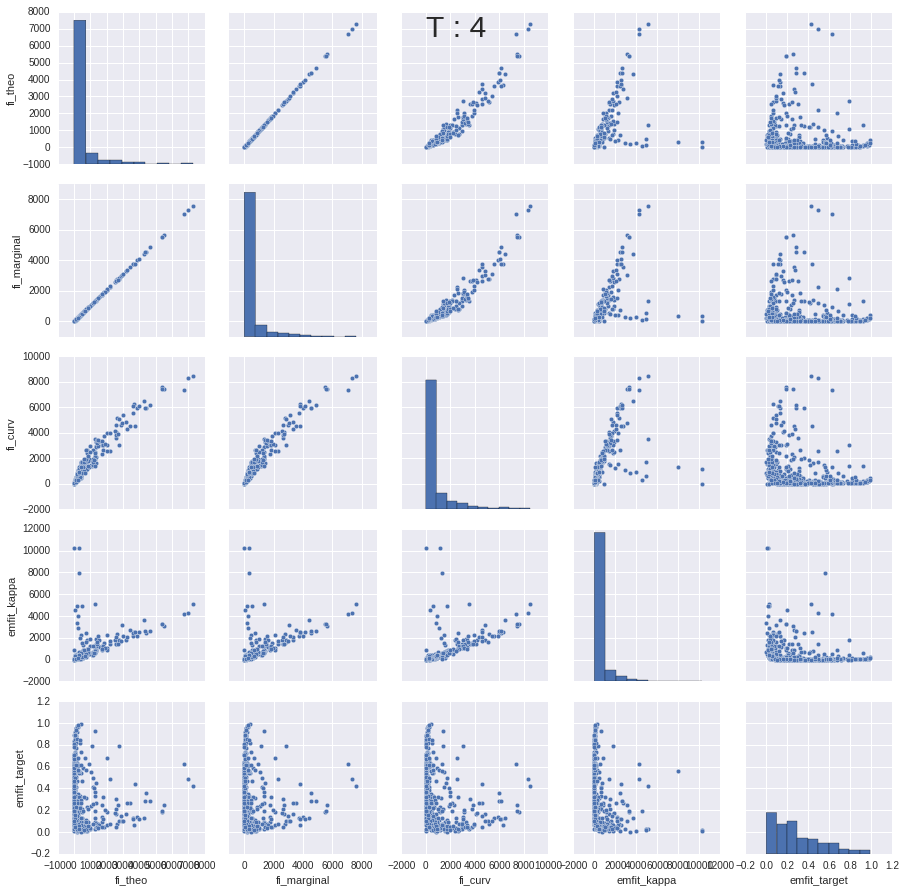

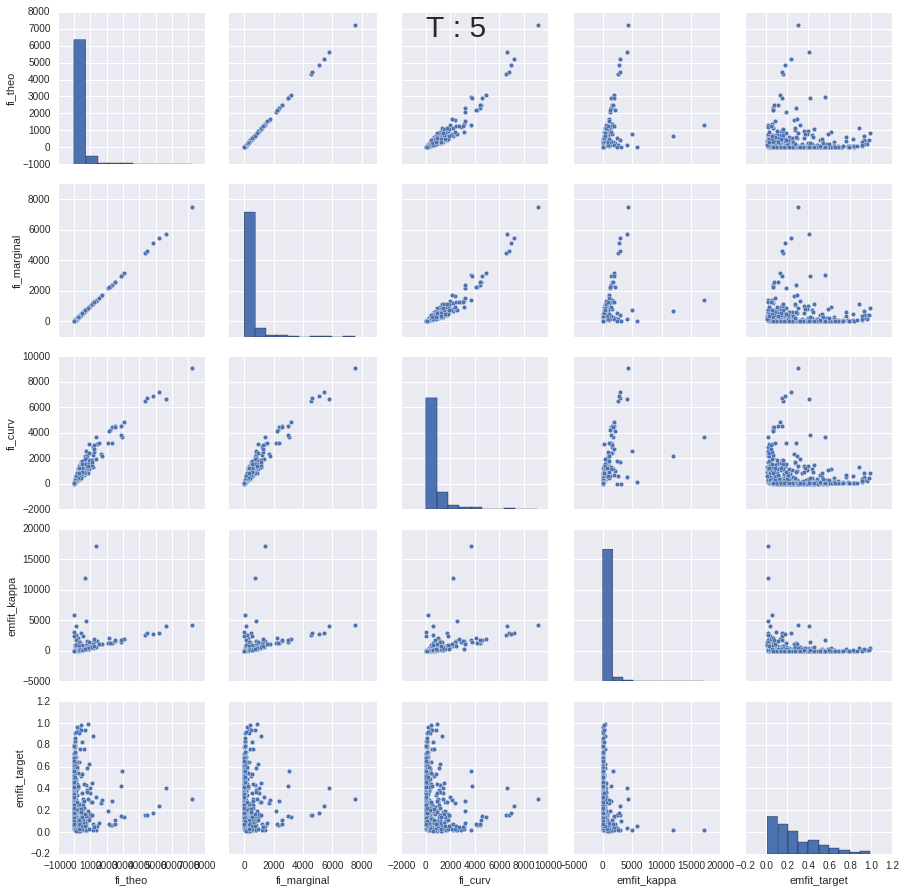

In [220]:
for T, subdf in df_fits_filtered.groupby('T'):
    g = sns.pairplot(subdf,
                 x_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa', 'emfit_target'],
                 y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa', 'emfit_target'],
                )
    g.fig.suptitle("T : %d "% T, fontsize=30)
    